In [1]:
#Importing required libraries
import librosa
import soundfile
import pandas as pd,numpy as np
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import seaborn as sns
import soundfile as sf
import pyloudnorm as pyln
from xgboost import XGBClassifier
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

file_dir="./data/"

#Emotion dictionary with emotion code
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}


#Getting all audio files paths
audio_files = []
for (dirpath, dirnames, filenames) in os.walk("./data"):
        audio_files.extend([dirpath.split('\\')[-1]+'/'+file for file in filenames])

#Creeating dataframe with each filename and emotion
person=[]
filename=[]
emotion=[]
emotioncd=[]
for file in audio_files:
    person.append(file.split('/')[0])
    filename.append(file.split('/')[1])
    emotion.append(emotions[str(file.split('/')[1].split('-')[0])])
    emotioncd.append(str(file.split('/')[1].split('-')[0]))
speech_df=pd.DataFrame({'person':person,'filename':filename,'emotion':emotion,'emotioncd':emotioncd})

In [2]:
len(audio_files)

1440

In [3]:
speech_df

,person,filename,emotion,emotioncd
0,Person01,01-01-01-01-01.wav,neutral,01
1,Person01,01-01-01-02-01.wav,neutral,01
2,Person01,01-01-02-01-01.wav,neutral,01
3,Person01,01-01-02-02-01.wav,neutral,01
4,Person01,02-01-01-01-01.wav,calm,02
...,...,...,...,...
1435,Person24,08-01-02-02-24.wav,surprised,08
1436,Person24,08-02-01-01-24.wav,surprised,08
1437,Person24,08-02-01-02-24.wav,surprised,08
1438,Person24,08-02-02-01-24.wav,surprised,08


In [4]:
speech_df.describe()

,person,filename,emotion,emotioncd
count,1440,1440,1440,1440
unique,24,1440,8,8
top,Person06,07-01-02-01-03.wav,calm,02
freq,60,1,192,192


In [5]:
pd.DataFrame(speech_df.groupby('emotion')['filename'].count()).rename(columns={'filename':'count'}).reset_index()

,emotion,count
0,angry,192
1,calm,192
2,disgust,192
3,fearful,192
4,happy,192
5,neutral,96
6,sad,192
7,surprised,192


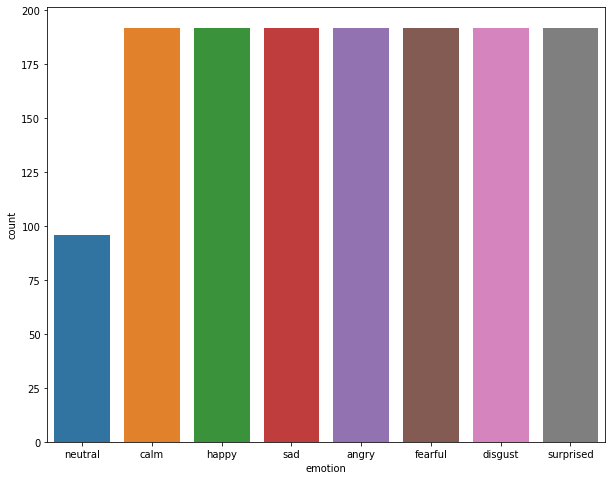

In [6]:
plt.figure(figsize = (10, 8))
sns.countplot(speech_df['emotion'])
plt.show()

In [7]:
#for ind in speech_df.index:
#    filepath=file_dir+speech_df['person'][ind]+"/"+speech_df['filename'][ind]
#    #print(filepath)
#    data, rate = sf.read(filepath)
#    meter = pyln.Meter(rate)
#    loudness = meter.integrated_loudness(data)
#    perceived_loudness.append(loudness)
#    
#for ind in speech_df.index:
#    filepath=file_dir+speech_df['person'][ind]+"/"+speech_df['filename'][ind]
#    #print(filepath)
#    data, rate = librosa.core.load(filepath)
#    try:
#        mfccs =np.mean(librosa.feature.mfcc(data, sr=rate,n_mfcc=13).T, axis=0)
#    except:
#        mfccs =np.mean(librosa.feature.mfcc(data[0], sr=rate,n_mfcc=13).T, axis=0)
#    mfcc.append(mfccs)
#    
#for ind in speech_df.index:
#    filepath=file_dir+speech_df['person'][ind]+"/"+speech_df['filename'][ind]
#    #print(filepath)
#    data, rate = librosa.core.load(filepath)
#    try:
#        zc = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
#    except:
#        zc = np.mean(librosa.feature.zero_crossing_rate(y=data[0]).T, axis=0)
#    zcr.append(zc)

# Feature Extraction

In [7]:
perceived_loudness=[]
mfcc=[]
zcr=[]


for ind in speech_df.index:
    filepath=file_dir+speech_df['person'][ind]+"/"+speech_df['filename'][ind]
    #Percevied Loudness
    data, rate = sf.read(filepath)
    meter = pyln.Meter(rate)
    loudness = meter.integrated_loudness(data)
    perceived_loudness.append(loudness)
    #MFCC
    try:
        mfccs =np.mean(librosa.feature.mfcc(data, sr=rate,n_mfcc=13).T, axis=0)
    except:
        mfccs =np.mean(librosa.feature.mfcc(data[0], sr=rate,n_mfcc=13).T, axis=0)
    mfcc.append(mfccs)
    #Zero Crossing Rate
    try:
        zc = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    except:
        zc = np.mean(librosa.feature.zero_crossing_rate(y=data[0]).T, axis=0)
    zcr.append(zc)
    
    

zero_crossing_rate=[values[0] for values in zcr]
features=pd.DataFrame(mfcc)
features['zcr']=zero_crossing_rate
features['pl']=perceived_loudness

C:\Users\anish.goyal\AppData\Local\Continuum\anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2
  n_fft, y.shape[-1]
C:\Users\anish.goyal\AppData\Local\Continuum\anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2
  n_fft, y.shape[-1]
C:\Users\anish.goyal\AppData\Local\Continuum\anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2
  n_fft, y.shape[-1]
C:\Users\anish.goyal\AppData\Local\Continuum\anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2
  n_fft, y.shape[-1]
C:\Users\anish.goyal\AppData\Local\Continuum\anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2
  n_fft, y.shape[-1]


In [8]:
zero_crossing_rate=[values[0] for values in zcr]
features=pd.DataFrame(mfcc)
features['zcr']=zero_crossing_rate
features['pl']=perceived_loudness

features.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,zcr,pl
0,1.000000,-0.384689,-0.687273,-0.573571,-0.502129,-0.454851,-0.512711,-0.375180,-0.230843,-0.368306,-0.456061,-0.155009,-0.231262,0.535823,0.943158
1,-0.384689,1.000000,0.561485,0.549834,0.694977,0.737725,0.508896,0.351402,0.305594,0.328069,0.321879,0.211828,0.413340,-0.279955,-0.523450
2,-0.687273,0.561485,1.000000,0.819882,0.683892,0.726401,0.755820,0.643230,0.498711,0.609474,0.427563,0.219420,0.477295,-0.497895,-0.702138
3,-0.573571,0.549834,0.819882,1.000000,0.629561,0.701813,0.738141,0.639625,0.441327,0.606419,0.454640,0.166554,0.479670,-0.384203,-0.655328
4,-0.502129,0.694977,0.683892,0.629561,1.000000,0.782457,0.646870,0.537430,0.612733,0.512243,0.464179,0.421583,0.460227,-0.429318,-0.531058
5,-0.454851,0.737725,0.726401,0.701813,0.782457,1.000000,0.704531,0.499114,0.565630,0.528781,0.369201,0.386226,0.586265,-0.368210,-0.520269
6,-0.512711,0.508896,0.755820,0.738141,0.646870,0.704531,1.000000,0.620959,0.563068,0.647587,0.367548,0.281051,0.662307,-0.544785,-0.514318
7,-0.375180,0.351402,0.643230,0.639625,0.537430,0.499114,0.620959,1.000000,0.510079,0.433340,0.466850,0.268715,0.447622,-0.366027,-0.379347
8,-0.230843,0.305594,0.498711,0.441327,0.612733,0.565630,0.563068,0.510079,1.000000,0.513981,0.230608,0.485668,0.546893,-0.476023,-0.174397
9,-0.368306,0.328069,0.609474,0.606419,0.512243,0.528781,0.647587,0.433340,0.513981,1.000000,0.346727,0.168538,0.591340,-0.405761,-0.379992


In [41]:
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#
#lda=LinearDiscriminantAnalysis(n_components=6)
#lda_model=lda.fit(X_train,y_train)
#
#sum(lda_model.explained_variance_ratio_)

In [ ]:
chroma=[]
for ind in speech_df.index:
    filepath=file_dir+speech_df['person'][ind]+"/"+speech_df['filename'][ind]
    data, rate = sf.read(filepath)
    try:
        stft = np.abs(librosa.stft(data))
    except:
        stft = np.abs(librosa.stft(data[0]))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=rate).T, axis=0)
    chroma.append(chroma_stft)
    

In [ ]:
chroma_df=pd.DataFrame(chroma)

In [ ]:
chroma_df.columns=['chroma_'+str(col) for col in chroma_df.columns]

In [ ]:
chroma_df

In [ ]:
features1=pd.concat([features,chroma_df],axis=1)

In [ ]:
features=features1

In [ ]:
#lda=LinearDiscriminantAnalysis(n_components=1)
#lda_model=lda.fit_transform(X_train,y_train)

In [9]:
features['Y']= speech_df['emotion']

In [10]:
X = features.iloc[: ,:-1].values
Y = features['Y'].values

encoder = OneHotEncoder()
Y_encoded = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [11]:
def split_normalize_data(X,Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train = (X_train - mean)/std
    X_test = (X_test - mean)/std
    return X_train, X_test, y_train, y_test


# Model - Decision Tree Classifier

In [12]:
X_train, X_test, y_train, y_test=split_normalize_data(X,Y)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.predict(X_test)
accuracy=clf.score(X_test, y_test)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
filename = 'decisiontree_model.pickle'
pickle.dump(clf, open(filename, 'wb'))

(1080, 15) (1080,) (360, 15) (360,)
Accuracy: 38.33%


# Model - XGBoost

In [13]:
X_train, X_test, y_train, y_test=split_normalize_data(X,Y)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
filename = 'xgb_model.pickle'
pickle.dump(model, open(filename, 'wb'))

(1080, 15) (1080,) (360, 15) (360,)


C:\Users\anish.goyal\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:27:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 55.83%


# Random Forest

In [14]:
X_train, X_test, y_train, y_test=split_normalize_data(X,Y)

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

(1080, 15) (1080,) (360, 15) (360,)


C:\Users\anish.goyal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 33.06%


# Gradient Boost

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

grid = {
    'learning_rate': [0.03, 0.1, 0.5], 
    'n_estimators': [100, 300], 
    'max_depth': [1, 3, 9]
}

m3 = GridSearchCV(GradientBoostingClassifier(), grid, verbose = 2)
m3.fit(X_train, y_train) 

C:\Users\anish.goyal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.03, max_depth=1, n_estimators=100 ...............
[CV]  learning_rate=0.03, max_depth=1, n_estimators=100, total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] learning_rate=0.03, max_depth=1, n_estimators=100 ...............
[CV]  learning_rate=0.03, max_depth=1, n_estimators=100, total=   0.7s
[CV] learning_rate=0.03, max_depth=1, n_estimators=100 ...............
[CV]  learning_rate=0.03, max_depth=1, n_estimators=100, total=   0.7s
[CV] learning_rate=0.03, max_depth=1, n_estimators=300 ...............
[CV]  learning_rate=0.03, max_depth=1, n_estimators=300, total=   1.9s
[CV] learning_rate=0.03, max_depth=1, n_estimators=300 ...............
[CV]  learning_rate=0.03, max_depth=1, n_estimators=300, total=   2.2s
[CV] learning_rate=0.03, max_depth=1, n_estimators=300 ...............
[CV]  learning_rate=0.03, max_depth=1, n_estimators=300, total=   1.9s
[CV] learning_rate=0.03, max_depth=3, n_estimators=100 ...............
[CV]  learning_rate=0.03, max_depth=3, n_estimators=100, total=   1.3s
[CV] learning_rate=0.03, max_depth=3, n_estimators=100 ...............
[CV]  learning_rate=0.03, max_depth=3, n_estimators=100, total=   1.4s
[CV] l

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  2.0min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  pre

In [16]:
pred3 = m3.predict(X_test)

print(classification_report(y_test, pred3))
accuracy = accuracy_score(y_test, pred3)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

              precision    recall  f1-score   support

       angry       0.61      0.67      0.64        45
        calm       0.56      0.63      0.59        54
     disgust       0.60      0.52      0.56        46
     fearful       0.49      0.40      0.44        47
       happy       0.55      0.55      0.55        42
     neutral       0.60      0.43      0.50        28
         sad       0.38      0.51      0.44        45
   surprised       0.49      0.45      0.47        53

    accuracy                           0.53       360
   macro avg       0.53      0.52      0.52       360
weighted avg       0.53      0.53      0.52       360

Accuracy: 52.50%
